# Problem Statement
To predict the presence of perceptual brand attributes in the images that consumers post online. 

### Please refer to notebook Train_Validation_Test_Split for more details about problem statement.

This notebook expects that user has already run Train_Validation_Test_Split to preprocess the training data. 

Since we are using one vs rest approach to solve the multiclass problem, we need to create 4 classfiers, one for each attribute. Each classifier needs to have its own dataset, with one attribute beling classfied as positive, and all other images being classified as negative. 

Since training dataset is quite large, and we cannot load 4 datasets into memory at the same time, we need to run this notebook 4 times to create/train 4 classifiers. 

## Importing Libraries

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
try: 
  print('set memory growth')
  tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
  # Invalid device or cannot modify virtual devices once initialized. 
  pass 

set memory growth


In [2]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2
import os


Using TensorFlow backend.


In [3]:
IMG_WIDTH=300
IMG_HEIGHT=300
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)

## Load training and validation data. 
Change the training/validation data file name corresponding to the model being trained. We need tp train 4 models, and for each model we need to use different dataset.

We have already save X_train/y_train in the previous notebook. Now we read training/validation data corresponding to each attribute and train the corresponding model. 

 - X_train_0 / X_val_0 : Training / Validation data corresponding to Attribute Glamarous
 - X_train_1 / X_val_1 : Training / Validation data corresponding to Attribute Rugged
 - X_train_2 / X_val_2 : Training / Validation data corresponding to Attribute Fun
 - X_train_3 / X_val_3 : Training / Validation data corresponding to Attribute Healthy

In [4]:
X_train = np.load('5000//X_train_3.npy')
X_val = np.load('5000//X_val_3.npy')

y_train = np.load('5000//y_train_3.npy')
y_val = np.load('5000//y_val_3.npy')

In [5]:
'''
Run this code for healthy attribute only(Disable this code while training classifiers for other attributes)

For healthy attribute, number of images(400) are 1/5 of other attrivbutes(2000). 
For this attribute, training data will be higly unbalanced, as nu of positives samples is very small compared to negative samples. 
For this attrivute, we run this code, to remove negative sample from the training data so that positive and negative classes
become balanced. 

'''

index = np.where(y_train == 1)

X_pos = X_train[index]
y_pos= y_train[index]

print(X_pos.shape)
print(y_pos.shape)
index = np.where(y_train == 0)
X_neg = X_train[index]
y_neg= y_train[index]
X_neg = X_neg[0:X_pos.shape[0]]
y_neg = y_neg[0:X_pos.shape[0]]
print(X_neg.shape)
print(y_neg.shape)

X_train = np.hstack((X_pos, X_neg))
y_train = np.hstack((y_pos, y_neg))
print(X_train.shape)
print(y_train.shape)

X_train, y_train = shuffle(X_train, y_train, random_state=0)

(363,)
(363,)
(363,)
(363,)
(726,)
(726,)


## Load image data into ram

In [6]:
X_train= X_train.flatten()
X_train = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in X_train.tolist()]
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val=   X_val.flatten()
X_val = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in X_val.tolist()]
X_val = np.array(X_val)
y_val = np.array(y_val)
print( X_train.shape)
print( y_train.shape)
print( X_val.shape)
print( y_val.shape)

(726, 300, 300, 3)
(726,)
(643, 300, 300, 3)
(643, 1)


### Create Data augmentation framework

In [7]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [8]:
it = datagen.flow(X_train, y_train)

## Model Implementation
 - We are going to use pre trained resnet model 
 - do not want to load the last fully connected layers which act as the classifier 
 - Freeze the weights of the model by setting trainable as false
 - add our own fully connected layers on top of the ResNet50 model for our task-specific classification.



In [9]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
# We do not want to load the last fully connected layers which act as the classifier we can add our 
# own fully connected layers on top of the ResNet50 model for our task-specific classification.

output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output=output)

#freeze the weights of the model by setting trainable as “False”
restnet.trainable = True
set_trainable = False
    
for layer in restnet.layers:
    if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
        set_trainable = True
    if set_trainable:
        layer.trainable = False
    else:
        layer.trainable = False
restnet.summary()

C:\Users\neera\anaconda3\envs\tf_gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

C:\Users\neera\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  import sys


## Add task specific fully connected layer to fine tune the model for classification purpose

In [10]:
input_shape=(IMG_HEIGHT,IMG_WIDTH,3)

model = Sequential()
model.add(restnet)
model.add(Dense(64, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 204800)            23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                13107264  
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 36,699,201
Trainable params: 13,111,489
Non-trainable params: 23,587,712
_________________________________

## Training with augmented data

In [11]:
history =      model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                        epochs=4,
                        steps_per_epoch=len(X_train) / 32,
                        validation_data=(X_val,y_val) ,
                        verbose=1)

Epoch 1/4


C:\Users\neera\anaconda3\envs\tf_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\neera\anaconda3\envs\tf_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


23/22 [==============================] - 45s 2s/step - loss: 0.9098 - accuracy: 0.5468 - val_loss: 0.5473 - val_accuracy: 0.7263
Epoch 2/4
23/22 [==============================] - 37s 2s/step - loss: 0.7042 - accuracy: 0.6226 - val_loss: 0.4717 - val_accuracy: 0.7932
Epoch 3/4
23/22 [==============================] - 37s 2s/step - loss: 0.6319 - accuracy: 0.6529 - val_loss: 0.3435 - val_accuracy: 0.8554
Epoch 4/4
23/22 [==============================] - 38s 2s/step - loss: 0.5318 - accuracy: 0.7493 - val_loss: 0.3880 - val_accuracy: 0.8196


### Train with original training data

In [12]:
history =      model.fit(X_train,
                        y_train,
                        epochs=3,
                        batch_size = 30,
                        validation_data=(X_val,y_val) ,
                        verbose=1)

Train on 726 samples, validate on 643 samples
Epoch 1/3
726/726 [==============================] - 43s 59ms/step - loss: 0.4866 - accuracy: 0.7700 - val_loss: 0.2340 - val_accuracy: 0.9082
Epoch 2/3
726/726 [==============================] - 40s 55ms/step - loss: 0.3188 - accuracy: 0.8650 - val_loss: 0.3203 - val_accuracy: 0.8678
Epoch 3/3
726/726 [==============================] - 40s 55ms/step - loss: 0.2751 - accuracy: 0.8774 - val_loss: 0.2760 - val_accuracy: 0.8834


## Visualisation

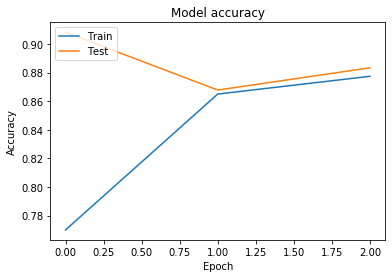

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

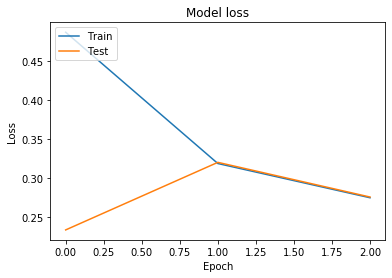

In [14]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

## Save Model
We need to save 4 models. As we cannot train the model simultaneously because of gpu memory limitations, we need to run this notebook 4 times, to train each model independently. Please change the model name corresponding to the attribute being trained. 

In [15]:
model.save('./savemodels_4/healthy_model_1.h5')

In [16]:
model.save_weights('./checkpoints/my_checkpoint')